# An introduction to Biogeme

#### for more examples see here: https://github.com/alvarogutyerrez/TheDiscreteChoiceDataBank

In [1]:
import pandas  as pd
import numpy as np
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.optimization as opt
import biogeme.results as res
from biogeme.expressions import Beta, DefineVariable
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**Import Swissmetro data**

In [2]:
df = pd.read_csv("swissmetro.dat",sep='\t')

* dataset consists of survey data collected on the trains between St. Gallen and Geneva, Switzerland, during March 1998
* It is necessary to obtain data from surveys of hypothetical markets/situations, which include the innovation, to assess the impact. 
* Survey data were collected on rail-based travels, interviewing 470 respondents. Due to data problems, only 441 are used here. A similar method for relevant car trips. A total of 1070 persons filled in the survey completely and were willing to participate in the second SP survey, which was generated using the same approach used for the rail interviews. 750 usable SP surveys were returned, from the license-plate based survey.
* Nine stated choice situations were generated for each the respondents, offering three alternatives: rail, Swissmetro and car

Bierlaire, M., Axhausen, K. and Abay, G. (2001), The acceptance of modal innovation: The case of Swissmetro, in ‘Proceedings of the Swiss Transport Research Conference’, Ascona, Switzerland.

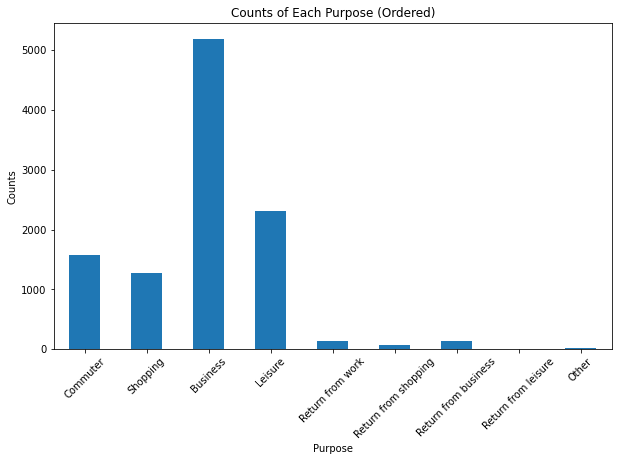

In [3]:
purpose_order = [1, 2, 3, 4, 5, 6, 7, 8, 9]
purpose_labels = ['Commuter', 'Shopping', 'Business', 'Leisure', 
                  'Return from work', 'Return from shopping', 
                  'Return from business', 'Return from leisure', 'Other']

df['PURPOSE'] = pd.Categorical(df['PURPOSE'], categories=purpose_order, ordered=True)

plt.figure(figsize=(10, 6))
chart = df['PURPOSE'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Purpose')
plt.ylabel('Counts')
plt.title('Counts of Each Purpose (Ordered)')
plt.xticks(range(len(purpose_labels)), purpose_labels, rotation=45)  # Set custom tick labels
plt.show()

**Split the data to train and test**

In [4]:
df = pd.read_csv("swissmetro.dat",sep='\t')
df_train, df_test = train_test_split(df, test_size=0.4)

In [6]:
database_train = db.Database("data/swissmetro", df_train)
database_test = db.Database("data/swissmetro", df_test)

**Use collumn names as variables**

In [7]:
globals().update(database_train.variables)

**Exclude some unwanted entries**

In [8]:
exclude = (( PURPOSE != 1 ) * ( PURPOSE != 3 ) + ( CHOICE == 0 )) > 0

database_train.remove(exclude)
database_test.remove(exclude)

# Model specification

**Parameters to be estimated**

In [9]:
# Beta is a function for parameter estimation
# second parameter is a default value. starting point for estimation
# third and forth parameters are the upper bound and lower bound
# last paramter: if it is 0 the paramter will be estimated from data, if it is 1 it will take the starting point

ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 0)
ASC_SM = Beta('ASC_SM', 0, None, None, 1)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

**Definition of new variables**

In [10]:
SM_COST = SM_CO * (GA == 0)
TRAIN_COST = TRAIN_CO * (GA == 0)
CAR_AV_SP = CAR_AV * (SP != 0)
TRAIN_AV_SP = TRAIN_AV * (SP != 0)
TRAIN_TT_SCALED = TRAIN_TT / 100
TRAIN_COST_SCALED = TRAIN_COST / 100
SM_TT_SCALED = SM_TT / 100
SM_COST_SCALED = SM_COST / 100
CAR_TT_SCALED = CAR_TT / 100
CAR_CO_SCALED = CAR_CO / 100

**Specify of the utility functions**

In [11]:
V1 = ASC_TRAIN + B_TIME * TRAIN_TT_SCALED + B_COST * TRAIN_COST_SCALED

V2 = ASC_SM + B_TIME * SM_TT_SCALED + B_COST * SM_COST_SCALED

V3 = ASC_CAR + B_TIME * CAR_TT_SCALED + B_COST * CAR_CO_SCALED

**Associate the utility functions with the numbering of the alternatives**

In [12]:
V = {1: V1,
     2: V2,
     3: V3}

av = {1: TRAIN_AV_SP,
      2: SM_AV,
      3: CAR_AV_SP}

**Associate the availability conditions with the alternatives**

In [13]:
av = {1: TRAIN_AV_SP,
      2: SM_AV,
      3: CAR_AV_SP}

**Build a model**

In [14]:
logprob = models.loglogit(V, av, CHOICE)

In [15]:
biogeme  = bio.BIOGEME(database_train, logprob)

biogeme.modelName = "swissmetro_logit_train"

**Model estimation**

In [17]:
results = biogeme.estimate()
results.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-0.169958,0.056586,-3.003541,0.002669,0.073403,-2.315417,2.059013e-02
ASC_TRAIN,-0.688499,0.071076,-9.686771,0.000000,0.102686,-6.704892,2.015543e-11
B_COST,-1.108510,0.067253,-16.482651,0.000000,0.089362,-12.404742,0.000000e+00
B_TIME,-1.303772,0.073694,-17.691621,0.000000,0.128549,-10.142195,0.000000e+00


**Check the results**

In [40]:
betas = results.getBetaValues()
for k,v in betas.items():
    print(f"{k:10}=\t{v:.3g}")

ASC_CAR   =	-0.0915
ASC_TRAIN =	-0.639
B_COST    =	-1.05
B_TIME    =	-1.37


In [41]:
gs = results.getGeneralStatistics()

for k,v in gs.items():
    print("{}= {}".format(k.ljust(45),v[0]))

Number of estimated parameters               = 4
Sample size                                  = 4064
Excluded observations                        = 2372
Init log likelihood                          = -4180.5293003633715
Final log likelihood                         = -3190.556450063241
Likelihood ratio test for the init. model    = 1979.9457006002613
Rho-square for the init. model               = 0.23680562416201278
Rho-square-bar for the init. model           = 0.2358488075216767
Akaike Information Criterion                 = 6389.112900126482
Bayesian Information Criterion               = 6414.3525920835145
Final gradient norm                          = 0.01393507673680164
Nbr of threads                               = 8


In [22]:
biogeme.generateHtml = True
biogeme.generatePickle = True

print(f"HTML file:    {results.data.htmlFileName}")
print(f"Pickle file:  {results.data.pickleFileName }")

HTML file:    swissmetro_logit_train~00.html
Pickle file:  swissmetro_logit_train~00.pickle


In [23]:
prob_train = models.logit(V, av, 1)
prob_SM = models.logit(V, av, 2)
prob_car = models.logit(V, av, 3)

In [24]:
simulate ={'Prob. SM':  prob_SM ,
           'Prob. train':  prob_train ,
           'Prob. car': prob_car ,}

In [25]:
biogeme = bio.BIOGEME(database_test, simulate)
biogeme.modelName = "swissmetro_logit_test"

**Use Betas obtained from training data to calculate the probabilties for test data**

In [26]:
betas = biogeme.freeBetaNames

print('Extracting the following variables:')
for k in betas:
    print('\t',k)

results = res.bioResults(pickleFile='swissmetro_logit_train.pickle')
betaValues = results.getBetaValues ()

Extracting the following variables:
	 ASC_CAR
	 ASC_TRAIN
	 B_COST
	 B_TIME


In [27]:
simulatedValues = biogeme.simulate(betaValues)
simulatedValues.head(5)

,Prob. SM,Prob. train,Prob. car
2839,0.829476,0.170524,0.000000
847,0.749782,0.197144,0.053073
5106,0.513099,0.163889,0.323012
4399,0.692910,0.051420,0.255670
7899,0.272872,0.037818,0.689310


In [28]:
prob_max = simulatedValues.idxmax(axis=1)
prob_max = prob_max.replace({'Prob. train': 1, 'Prob. SM': 2, 'Prob. car': 3})
prob_max

2839    2
847     2
5106    2
4399    2
7899    3
       ..
53      2
7405    2
641     2
5415    2
5395    2
Length: 2734, dtype: int64

In [32]:
test_df = database_test.data
test_df['prediction'] = prob_max
test_df

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_CO,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,prediction
2839,2,0,1,316,3,0,6,1,1,2,...,2340,60,47,3120,20,0,0,0,1,2
847,2,0,1,95,1,1,6,2,1,3,...,5040,30,49,5040,10,0,156,104,2,2
5106,3,1,1,568,3,0,1,2,1,2,...,38,60,77,50,30,0,88,71,3,2
4399,3,1,1,489,1,1,1,2,0,4,...,126,30,123,137,30,0,160,175,2,2
7899,3,1,1,878,3,1,3,2,0,4,...,233,60,100,254,20,0,144,100,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2,0,1,6,1,0,1,1,1,3,...,35,30,53,46,20,1,70,45,2,2
7405,3,1,1,823,3,1,1,3,1,3,...,131,30,80,150,30,0,208,214,2,2
641,2,0,1,72,1,1,1,2,1,3,...,85,60,82,105,30,0,130,115,2,2
5415,3,1,1,602,3,0,3,1,0,3,...,133,60,103,144,20,0,144,104,3,2


In [33]:
test_df['CHOICE=prediction']=test_df.apply(lambda row: row.CHOICE==row.prediction, axis=1)
test_df

,GROUP,SURVEY,SP,ID,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,AGE,...,TRAIN_HE,SM_TT,SM_CO,SM_HE,SM_SEATS,CAR_TT,CAR_CO,CHOICE,prediction,CHOICE=prediction
2839,2,0,1,316,3,0,6,1,1,2,...,60,47,3120,20,0,0,0,1,2,False
847,2,0,1,95,1,1,6,2,1,3,...,30,49,5040,10,0,156,104,2,2,True
5106,3,1,1,568,3,0,1,2,1,2,...,60,77,50,30,0,88,71,3,2,False
4399,3,1,1,489,1,1,1,2,0,4,...,30,123,137,30,0,160,175,2,2,True
7899,3,1,1,878,3,1,3,2,0,4,...,60,100,254,20,0,144,100,3,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2,0,1,6,1,0,1,1,1,3,...,30,53,46,20,1,70,45,2,2,True
7405,3,1,1,823,3,1,1,3,1,3,...,30,80,150,30,0,208,214,2,2,True
641,2,0,1,72,1,1,1,2,1,3,...,60,82,105,30,0,130,115,2,2,True
5415,3,1,1,602,3,0,3,1,0,3,...,60,103,144,20,0,144,104,3,2,False


In [36]:
accuracy = test_df['CHOICE=prediction'].value_counts().get(True)/len(test_df)

print('Accuracy of the model:', accuracy)

Accuracy of the model: 0.6755669348939283
